# 相对强弱市场
*强者越强，弱者越弱*

## 目录
1. 什么是相对强弱？
2. 怎么计算相对强弱？
3. 如何用图形展示相对强弱？
4. 如何用相对强弱来编写策略？

## 什么是相对强弱？
一段时间内某股票和本行业的股票或整个市场的比较，即对该股票市场表现的计量。

## 怎么计算相对强弱？
RS = Stock/Index

MOM_RS = Momentum(RS)

MOM_MOM = Momentum(MOM_RS)

## 如何用图形展示相对强弱？

In [1]:
from jaqs_fxdayu.data import DataView
from jaqs_fxdayu.data import RemoteDataService
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

dataview_folder = '../Factor'
dv = DataView()
dv.load_dataview(dataview_folder)

D:\Anaconda3\lib\importlib\__init__.py:126: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _bootstrap._gcd_import(name[level:], package, level)


Dataview loaded successfully.


In [2]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df
stock = change_index(dv.get_ts('close_adj').loc[20170105:])
hs300 = change_index(dv.data_benchmark.loc[20170105:])

In [3]:
RS = stock['600036.SH']/hs300.close
RS = RS.dropna()
print (RS.tail())

2017-12-25    0.033548
2017-12-26    0.033928
2017-12-27    0.033357
2017-12-28    0.032977
2017-12-29    0.033327
dtype: float64


In [4]:
#Momentum_RS
import talib as ta

MOM_RS = ta.ROCR100(RS.values, 20)
MOM_MOM = ta.ROCR100(MOM_RS, 20)
data_s = stock['600036.SH']
data1 = pd.Series(MOM_RS, index=RS.index)
data2 = pd.Series(MOM_MOM, index=RS.index)
data = pd.concat([data_s, RS, data1, data2], axis=1)
data.columns = ['close', 'RS', 'MOM_RS', 'MOM_MOM']
print (data.tail())

                 close        RS      MOM_RS    MOM_MOM
2017-12-25  135.587218  0.033548   98.229352  92.275070
2017-12-26  137.531452  0.033928  101.836699  95.703934
2017-12-27  133.133779  0.033357   98.818309  91.211470
2017-12-28  132.531992  0.032977   98.443699  91.925767
2017-12-29  134.337353  0.033327  100.609734  95.288634


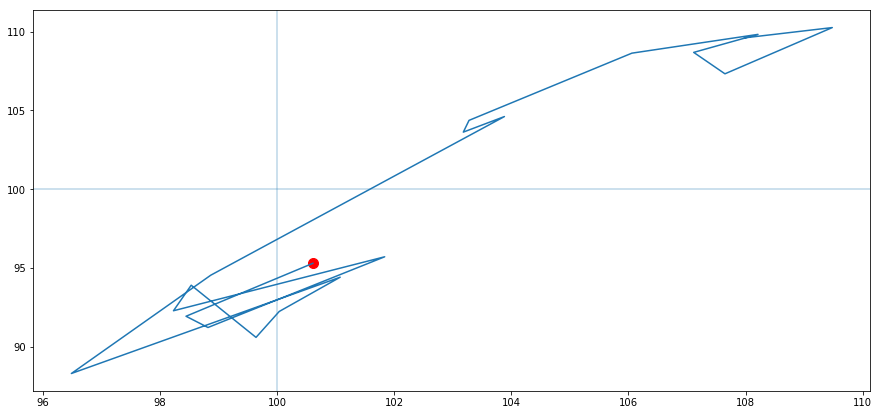

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(data.MOM_RS.tail(20).values, data.MOM_MOM.tail(20).values)
plt.axhline(100,alpha=0.3)
plt.axvline(100,alpha=0.3)
X=data['MOM_RS'].iloc[-1]
Y=data['MOM_MOM'].iloc[-1]
plt.scatter(X,Y,color='r', s=100)
plt.show()

## 如何用相对强弱来编写策略？
**买入时机：**

第一象限：（MOM_RS>100, MOM_MOM>100）

第四象限：（MOM_RS< 100, MOM_MOM >100）

**卖出时机**

第二象限：（MOM_RS > 100, MOM_MOM < 100）

第三象限：（MOM_RS< 100, MOM_MOM < 100）

In [1]:
#Relative_Strength

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import (CtaTemplate,
                                                     ArrayManager)
import talib as ta


########################################################################
class ROCRStrategy(CtaTemplate):
    className = 'ROCRStrategy'
    author = 'xingetouzi'


    # 策略参数
    ROCRPeriod = 80
    lots = 1
    stopRatio = 0.08  # 止损比例

    # 策略变量
    ROCRsignal = {}  
    transactionPrice = {}

    # 参数列表，保存了参数的名称
    paramList = ['className',
                 'author',
                 'symbolList',
                 'ROCRPeriod',
                 'lots',
                 'stopRatio']

    # 变量列表，保存了变量的名称
    varList = ['transactionPrice',
               'ROCRsignal']

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super(ROCRStrategy, self).__init__(ctaEngine, setting)

    # ----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.setArrayManagerSize(200)
        self.ROCRsignal = {s: 0 for s in self.symbolList}
        self.transactionPrice = {s: 0 for s in self.symbolList}
        self.putEvent()  # putEvent 能刷新策略UI界面的信息

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.putEvent()
        '''
        实盘在点击启动策略时, 此时的引擎下单逻辑改为True, 此时开始推送到onbar的数据, 会触发下单。
        '''

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.putEvent()

    # ----------------------------------------------------------------------
    def onRestore(self):
        """恢复策略（必须由用户继承实现）"""
        # 策略恢复会自动读取 varList 和 syncList 的数据，还原之前运行时的状态。
        # 需要注意的是，使用恢复，策略不会运行 onInit 和 onStart 的代码，直接进入行情接收阶段
        self.putEvent()

    # ----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        # 在每个Tick推送过来的时候,进行updateTick,生成分钟线后推送到onBar.
        # 需要注意的是，如果没有updateTick，实盘将不会推送1分钟K线
        pass

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        self.writeCtaLog(u'%s, bar.close%s, %s' % (symbol, bar.close, bar.datetime))  # 可以将实盘的运行情况记录到日志里

        # 持有多头仓位
        if self.posDict[symbol + "_LONG"] > 0:
            if (bar.close < self.transactionPrice[symbol] * (1 - self.stopRatio)) or \
                    (bar.close > self.transactionPrice[symbol] * (1 + 2 * self.stopRatio)):
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])

        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            if (bar.close > self.transactionPrice[symbol] * (1 + self.stopRatio)) or \
                    (bar.close < self.transactionPrice[symbol] * (1 - 2 * self.stopRatio)):
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])

        self.putEvent()  # 每分钟更新一次UI界面

    def on3MinBar(self, bar):
        """3分钟K线推送"""
        symbol = bar.vtSymbol

        am3 = self.getArrayManager(symbol, "3m")

        if not am3.inited:
            return

        MOM = ta.ROCR100(am3.close, self.ROCRPeriod)
        if len(MOM) > self.ROCRPeriod:
            MOM_MOM = ta.ROCR100(MOM, self.ROCRPeriod)

            if (MOM_MOM[-1] > 100) and (MOM_MOM[-2] < 100):
                self.ROCRsignal[symbol] = 1
            elif (MOM_MOM[-1] < 100) and (MOM_MOM[-2] > 100):
                self.ROCRsignal[symbol] = -1
            else:
                self.ROCRsignal[symbol] = 0

            if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
                if self.ROCRsignal[symbol] == 1:
                    self.buy(symbol, bar.close * 1.02, self.lots)
                if self.ROCRsignal[symbol] == -1:
                    self.short(symbol, bar.close * 0.98, self.lots)

    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        symbol = trade.vtSymbol
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onTrade
        self.transactionPrice[symbol] = trade.price

    # ----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function ROCRStrategy.onBar at 0x0000023073221E18>, <__main__.ROCRStrategy object at 0x0000023066250470>)
[DEBUG] 注册品种BTCUSDT:binance上的on_3Min_bar函数functools.partial(<function ROCRStrategy.on3MinBar at 0x0000023073221EA0>, <__main__.ROCRStrategy object at 0x0000023066250470>)
2018-11-24 13:19:34.872994	开始回测
2018-11-24 13:19:34.872994	策略初始化
2018-11-24 13:19:34.874992	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-24 13:20:14.911484	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-24 13:20:14.979449	载入完成，数据量：12000
2018-11-24 13:20:14.987440	策略初始化完成
2018-11-24 13:20:14.987440	策略启动完成
2018-11-24 13:20:14.989440	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-24 13:20:15.004440	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-24 13:20:55.468558	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-24 13:20:55.523525	载入完成，数据量：42270
2018-11-24 13:20:55.524528	当前回放数据:[2018

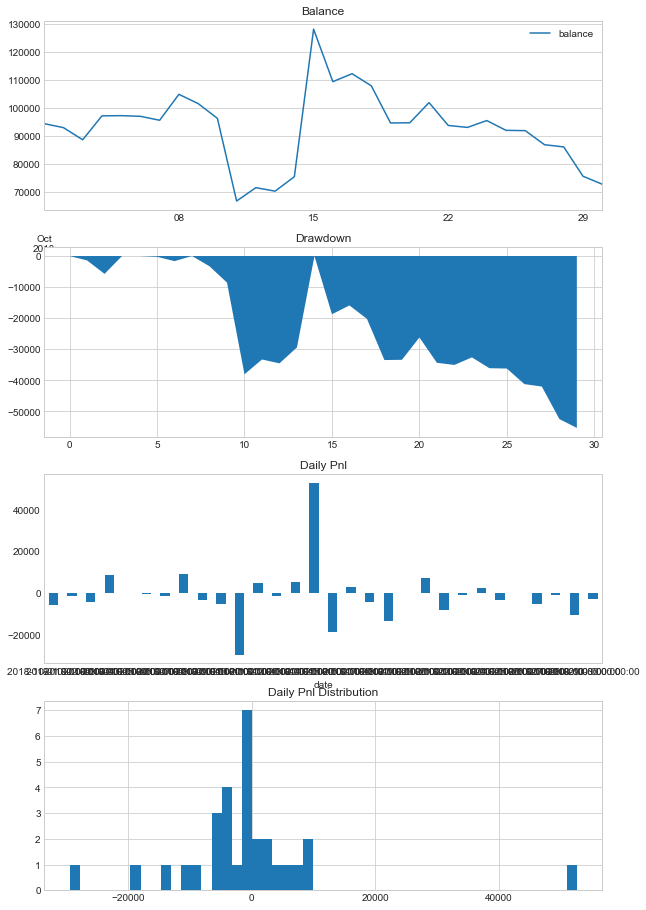

2018-11-24 13:22:10.635434	计算回测结果
2018-11-24 13:22:10.643430	交割单已生成
2018-11-24 13:22:10.644429	------------------------------
2018-11-24 13:22:10.644429	第一笔交易：	2018-10-30 23:58:00
2018-11-24 13:22:10.644429	最后一笔交易：	2018-10-30 23:58:00
2018-11-24 13:22:10.644429	总交易次数：	1
2018-11-24 13:22:10.644429	总盈亏：	-27,571.86
2018-11-24 13:22:10.644429	最大回撤: 	-27,571.86
2018-11-24 13:22:10.645428	平均每笔盈利：	-27,571.86
2018-11-24 13:22:10.645428	平均每笔滑点：	0.0
2018-11-24 13:22:10.645428	平均每笔佣金：	648.86
2018-11-24 13:22:10.645428	胜率		0.0%
2018-11-24 13:22:10.645428	盈利交易平均值	0
2018-11-24 13:22:10.645428	亏损交易平均值	-27,571.86
2018-11-24 13:22:10.645428	盈亏比：	-0.0
2018-11-24 13:22:11.000226	交易记录没有达到10笔！
2018-11-24 13:22:11.001225	计算按日统计结果


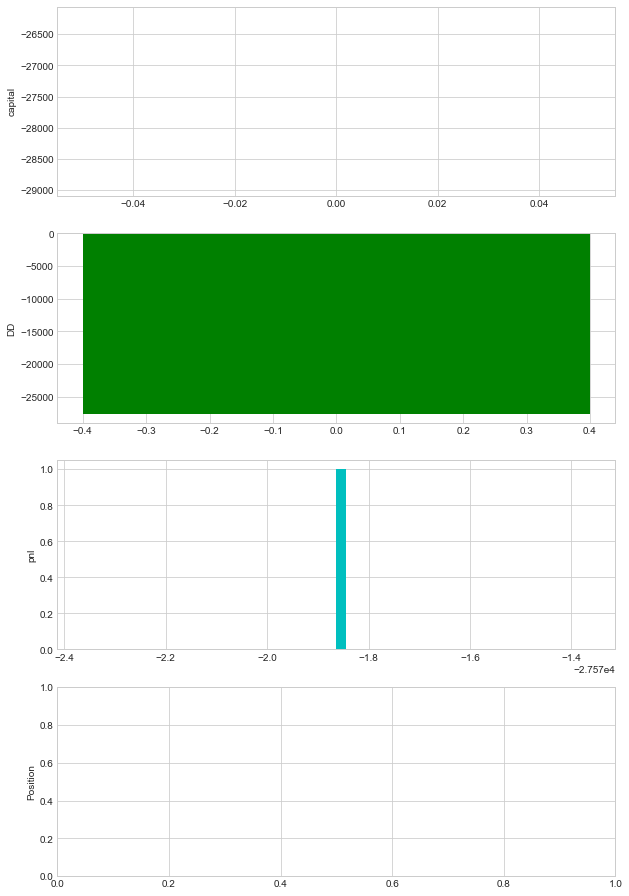

In [2]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSize(size)          # 设置合约大小
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(ROCRStrategy, {'symbolList': ['BTCUSDT:binance',
#                                                             'EOSUSDT:binance',
                                                            # 'ETHUSDT:binance'
#                                                             'eos_quarter:OKEX'
                                                            # 'tEOSUSD:bitfinex'
                                                            ]},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('ROCRStrategyReport.xlsx')

## 作业
根据以上代码做出其他象限进场的策略